In [1]:
# This is a cell to hide code snippets from displaying
# This must be at first cell!

from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [40]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [41]:
import os
import pandas as pd
import sys
import os
from subprocess import call

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from IPython.display import display, HTML
import numpy as np

import random
from scipy.stats import ttest_1samp
from sklearn.externals import joblib
from matplotlib.lines import Line2D

sys.path.append('../../')


from common_v2.plot_style_utils import task_names
import common_v2.plot_style_utils
import common_v2.plot_style_utils as plot_style_utils
from common_v2.validation_tools import regr_datasets, subsets, metrics, reps, transfer_datasets, pearson
import common_v2.validation_tools

random.seed(42)
np.random.seed(42)

# Supp. Data 3

In [42]:
path_to_pieces = f"../../../data/pieces_new/"

stds = pd.read_csv("../../../data/std_results_val_resamp.csv", index_col=0)

regr_datasets.loc[9] = 'rocklin_ssm2_nat_eng'

In [43]:
common_v2.plot_style_utils.set_pub_plot_context(colors='categorical', context="poster")

palette = sns.color_palette()

In [44]:
uni_color, rgn_color, arnold_color, baseline_color, fusion_color = [0,1,2,3,5]

rep_colors ={
    'RGN': palette[rgn_color],
    '64_avg_hidden': palette[uni_color],
    '64_final_hidden': palette[uni_color],
    '64_final_cell': palette[uni_color],
    '256_avg_hidden': palette[uni_color],
    '256_final_cell': palette[uni_color],
    'avg_hidden': palette[uni_color],
    'final_hidden': palette[uni_color],
    'final_cell': palette[uni_color],
    'arnold_original_3_7': palette[arnold_color],
    'arnold_scrambled_3_5': palette[arnold_color],
    'arnold_random_3_7': palette[arnold_color],
    'arnold_uniform_4_1': palette[arnold_color],
    'all_64': palette[uni_color],
    'all_256': palette[uni_color],
    'all_1900': palette[uni_color],
    'all_avg_hidden': palette[uni_color],
    'all_final_cell': palette[uni_color],
    'RGN_avg_hidden': palette[fusion_color],
    'RGN_final_cell': palette[fusion_color],
    'simple_freq_plus': palette[baseline_color],
    'simple_freq_and_len': palette[baseline_color],
    '2grams':  palette[baseline_color],
    '3grams':  palette[baseline_color],
    'tfidf_2grams': palette[baseline_color],
    'tfidf_3grams': palette[baseline_color],
    'mean': palette[baseline_color]
}


In [45]:
group_colors = {
    "UniRep": palette[uni_color], 
    "RGN": palette[rgn_color], 
    "Doc2Vec": palette[arnold_color], 
    "Baseline": palette[baseline_color], 
    "Fusion": palette[fusion_color]
}

scratch = pd.Series({
    "RGN": 0.5, 
    "Doc2Vec": 0.5, 
    "Baseline": 0.5, 
    "Fusion": 0.5,
    "UniRep": 0.5
})

l_fig, ax = plt.subplots(1, 1)

scratch.plot(kind='barh', color=[group_colors[n] for n in scratch.index], xticks=[], grid=0, figsize=(.7,1.3), ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.close()

#plot_style_utils.save_for_pub(l_fig, path=f"./figures/legend", dpi=500)

In [46]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [47]:
regr_datasets

0                  leuenberger
1                   solubility
2                   arnold_T50
3            arnold_absorption
4    arnold_enantioselectivity
5          arnold_localization
6                       fowler
7                 rocklin_ssm2
8              rocklin_all_rds
9         rocklin_ssm2_nat_eng
Name: dataset, dtype: object

In [48]:
regr_datasets = regr_datasets.drop([0,1])

In [49]:
d = 'leuenberger'
s = 'ecoli_tm'
rep = 'avg_hidden'
run_type = 'test'
metric = 'pearson_r'

to_plot = False

fig_n = 1

def get_tab_dict_and_plot(metric, to_plot=False, figsize=(7,7)):
    
    global fig_n
    
    tab_dict = {}

    for d in regr_datasets:
        ss = subsets[d]
        if (len(ss) > 1) & (d != 'rocklin_ssm2_nat_eng'):
            ss = list(ss)+["full"]
        for s in ss:
            rep_dict = {}
            std_dict = {}
            for rep in reps:
                try:
                    rep_dict[rep] = pd.read_csv(
                        f"../../../data/results/{d}__{s}__{rep}__{run_type}__regression_results.csv", header=None, index_col=0
                    ).loc[metric].iloc[0]
                    std_dict[rep] = stds.loc[f"{d}__{s}__{rep}__{run_type}"][metric]
                except Exception as e:
                    print(e)
                    #print(f"could not find ./results/{d}__{s}__{rep}__{run_type}__regression_results.csv")
            #print(f"{d} {s}")
            try:
                ser = pd.Series(rep_dict).sort_values(ascending=False)
                tab = pd.concat([ser, pd.Series(std_dict).loc[ser.index]], axis=1)
                tab.columns = ['avg','stdev']
                if to_plot:
                    
                    tab_to_plot = tab.copy()
                    
                    tab_to_plot.index = [common_v2.plot_style_utils.rep_names[n] for n in tab_to_plot.index]
                    
                    #display(tab)
                    
                    fig, ax = plt.subplots(1, 1)
                    tab_to_plot.avg.plot(kind='barh', color=[rep_colors[n] for n in tab.index], figsize=figsize, 
                            xerr=tab_to_plot.stdev, ax=ax
                        )
                    plt.xlabel("Mean Squared Error")
                    #display(l_fig)
                    display(fig)
                    plt.close()
                    if len(subsets[d]) > 1:
                        if s != 'full':
                            printmd(f"Supplementary Results Figure {fig_n}: All representation results in {task_names[d].lower()} task. Subset: {task_names[s]}. \n")
                        else:
                            printmd(f"Supplementary Results Figure {fig_n}: All representation results in {task_names[d].lower()} task, {task_names[s]}. \n")
                    else:
                        printmd(f"Supplementary Results Figure {fig_n}: All representation results in {task_names[d].lower()} task. \n")
                    
                    #custom_lines = [Line2D([0], [0], color=rep_colors[o], lw=4) for o in tab.index.tolist()]
                    #ax.legend(custom_lines, tab.index.tolist())

                    #plot_style_utils.save_for_pub(fig, path=f"./figures/{fig_n}__{d}__{s}__{run_type}", dpi=500)
                    #print('saving',f"./figures/{d}__{s}__{run_type}")
                    fig_n+=1
                    #plt.title(f"{d}__{s}__{run_type}")
                tab_dict[(d,s)] = tab
            except Exception as e:
                print(e)
    return tab_dict

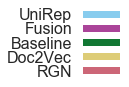

In [50]:
display(l_fig)

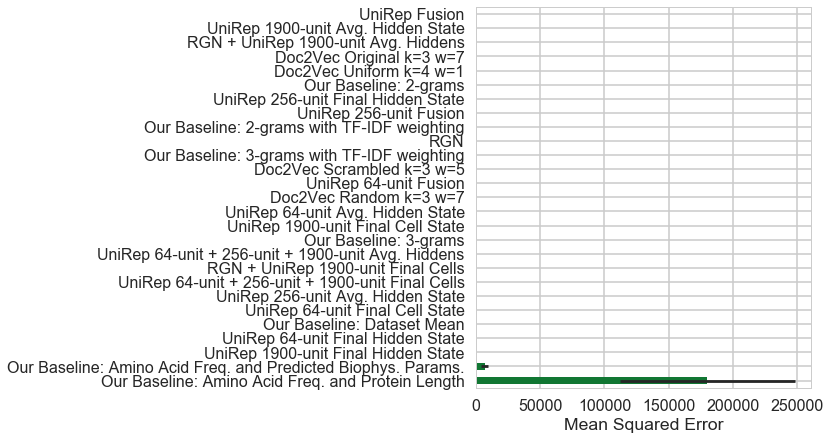

Supplementary Results Figure 1: All representation results in cytochrome p450 thermostability task. 


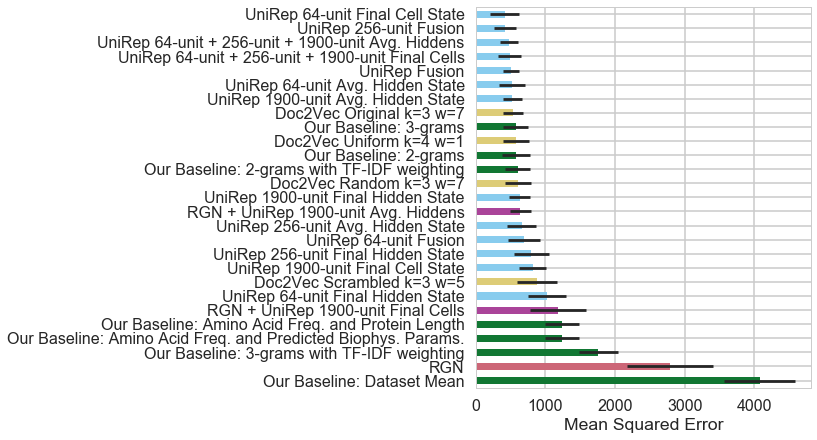

Supplementary Results Figure 2: All representation results in rhodopsin peak absorption wavelength task. 


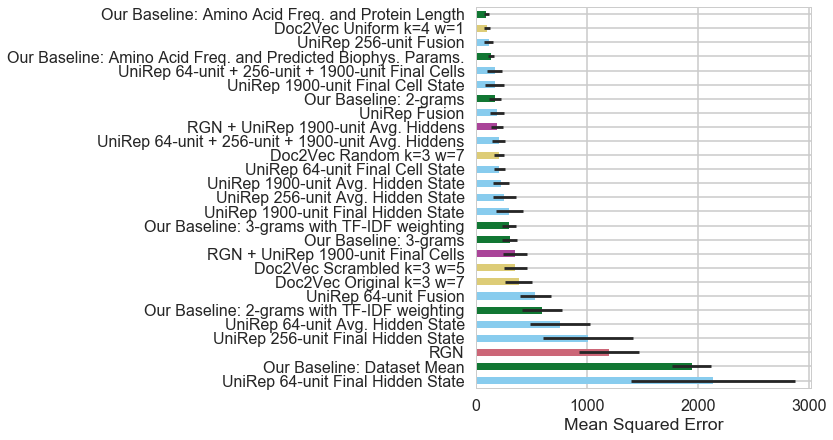

Supplementary Results Figure 3: All representation results in epoxide hydrolase enantioselectivity task. 


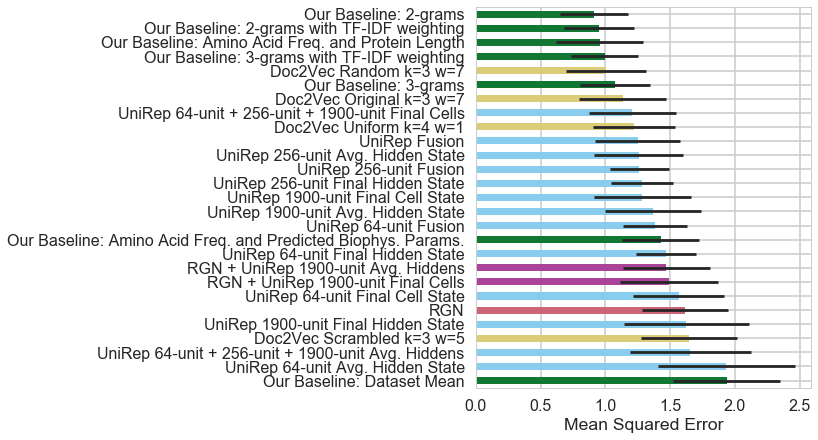

Supplementary Results Figure 4: All representation results in channelrhodopsin membrane localization task. 


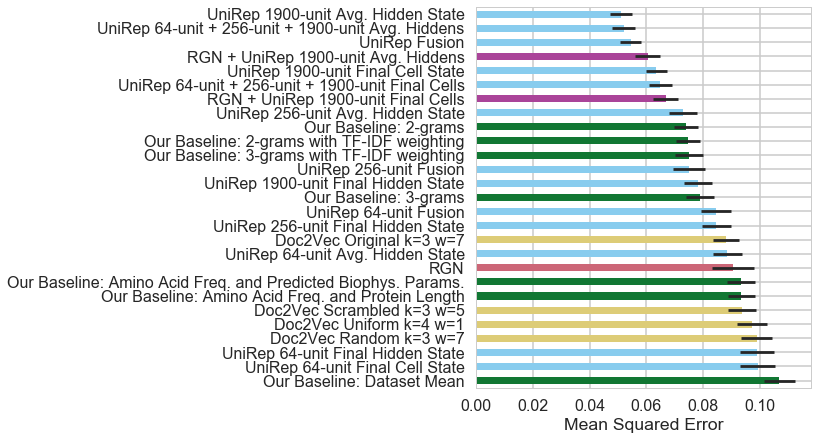

Supplementary Results Figure 5: All representation results in variant effect prediction task task. Subset: TEM-1 Beta-lactamase. 


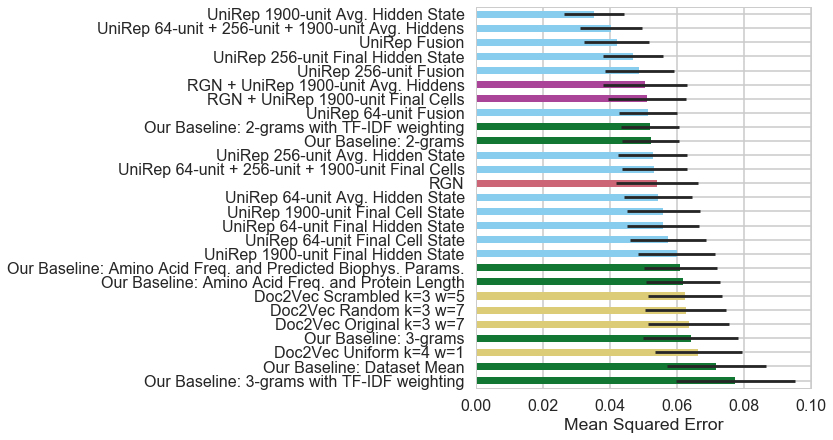

Supplementary Results Figure 6: All representation results in variant effect prediction task task. Subset: Ubiquitin (E1 Activity). 


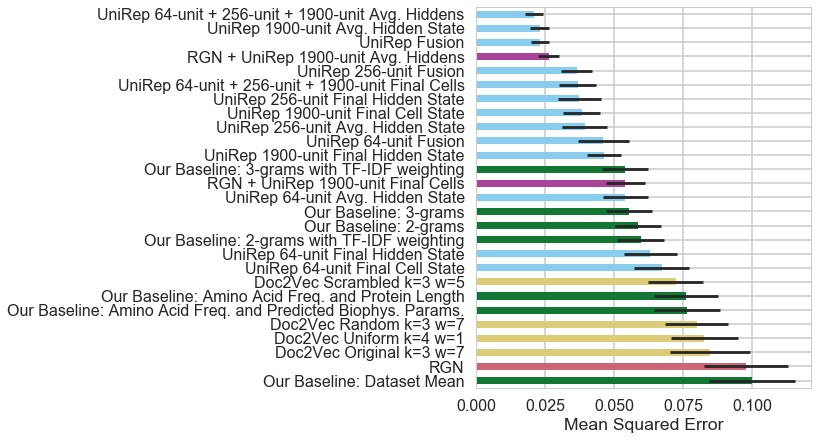

Supplementary Results Figure 7: All representation results in variant effect prediction task task. Subset: Protein G (IgG domain). 


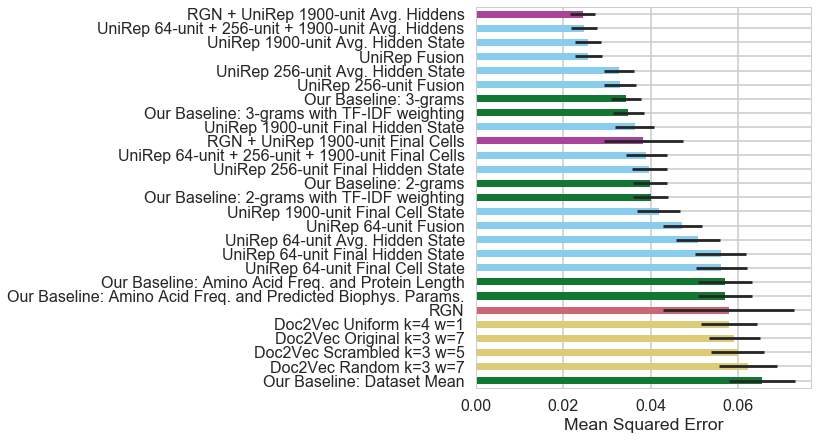

Supplementary Results Figure 8: All representation results in variant effect prediction task task. Subset: HSP90. 


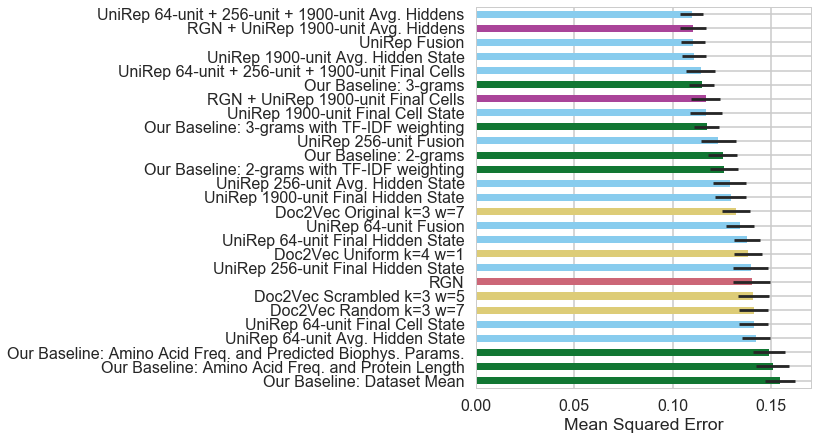

Supplementary Results Figure 9: All representation results in variant effect prediction task task. Subset: Aminoglycosidase (Kka2). 


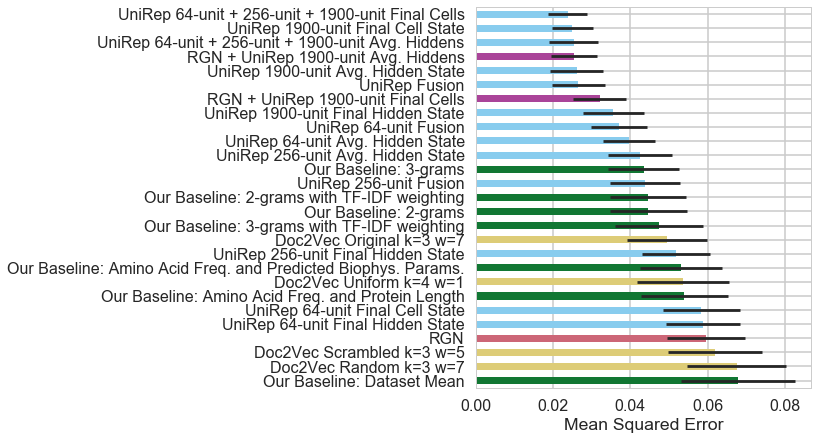

Supplementary Results Figure 10: All representation results in variant effect prediction task task. Subset: Pab1 (RRM domain). 


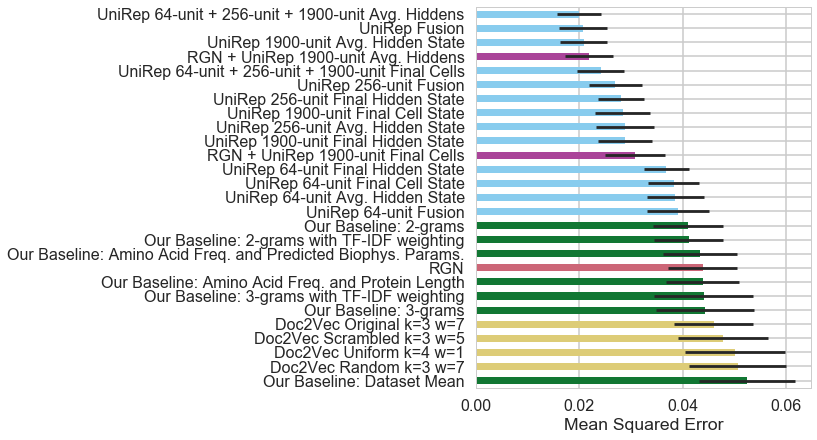

Supplementary Results Figure 11: All representation results in variant effect prediction task task. Subset: PSD95 (Pdz3 domain). 


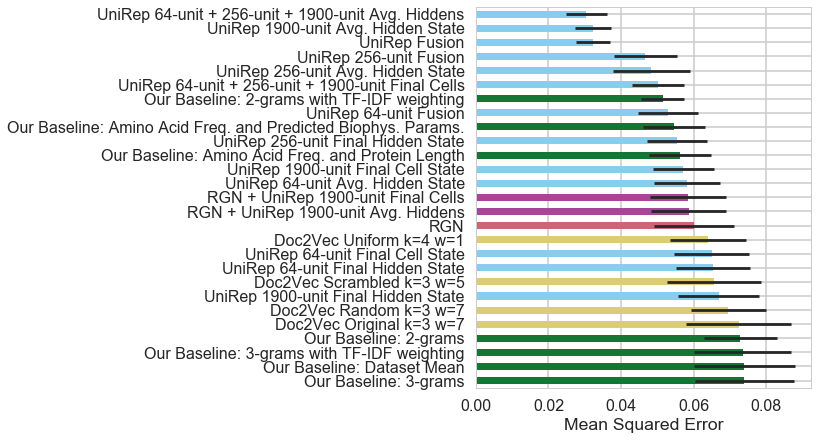

Supplementary Results Figure 12: All representation results in variant effect prediction task task. Subset: Ubiquitin. 


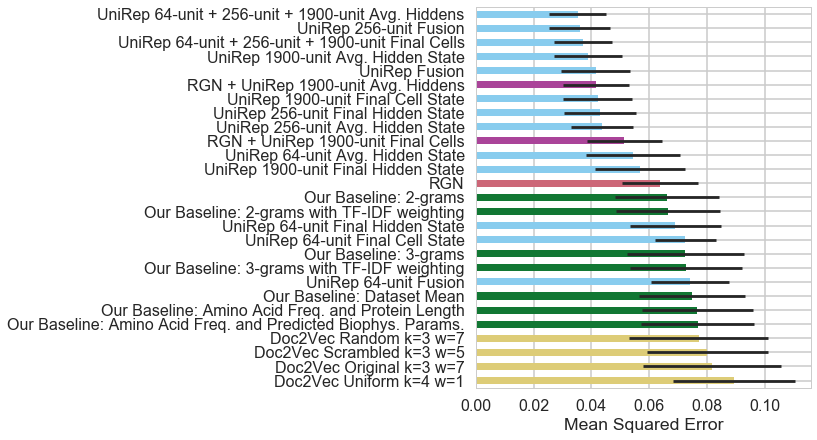

Supplementary Results Figure 13: All representation results in variant effect prediction task task. Subset: Yap65 (WW domain). 


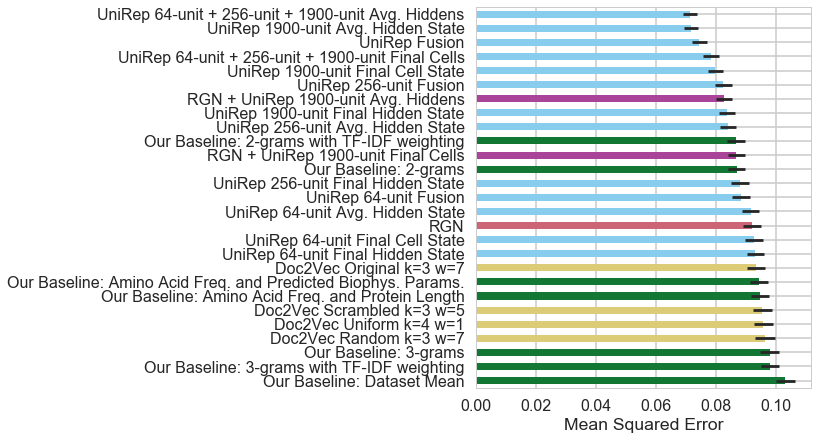

Supplementary Results Figure 14: All representation results in variant effect prediction task task, Combined Data. 


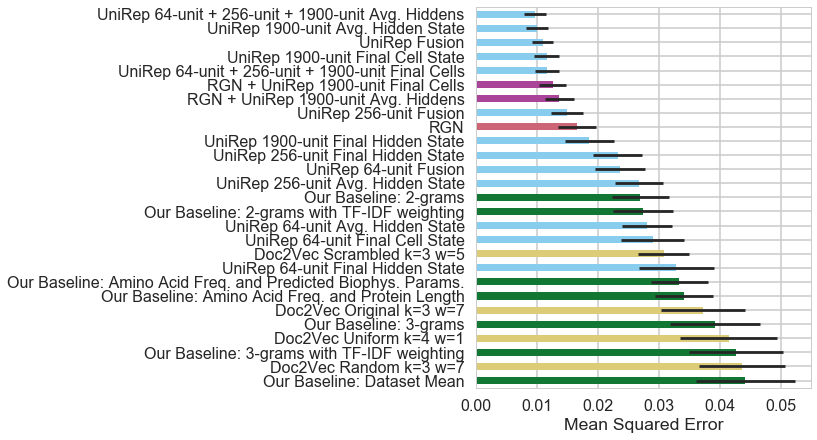

Supplementary Results Figure 15: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EEHEE_rd3_0037. 


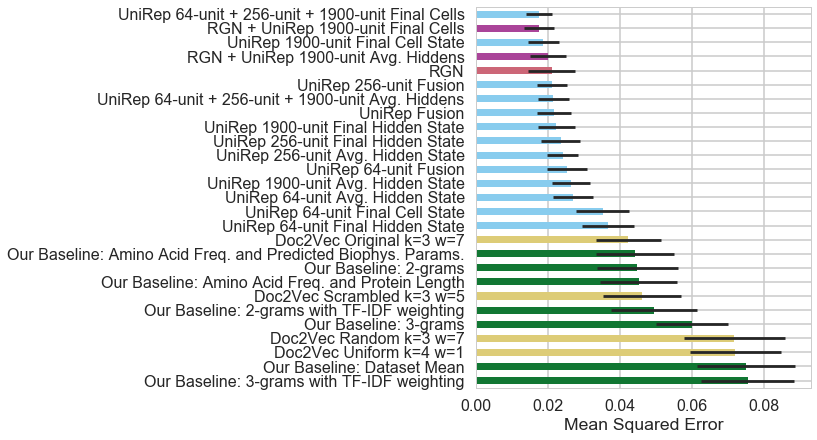

Supplementary Results Figure 16: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EEHEE_rd3_1498. 


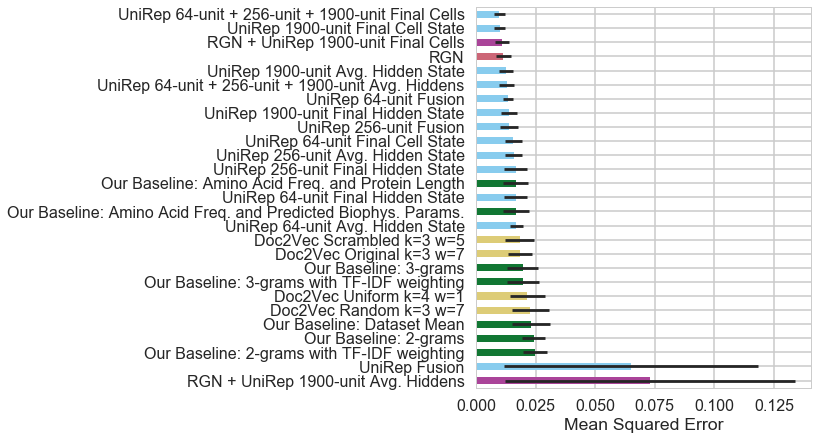

Supplementary Results Figure 17: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EEHEE_rd3_1702. 


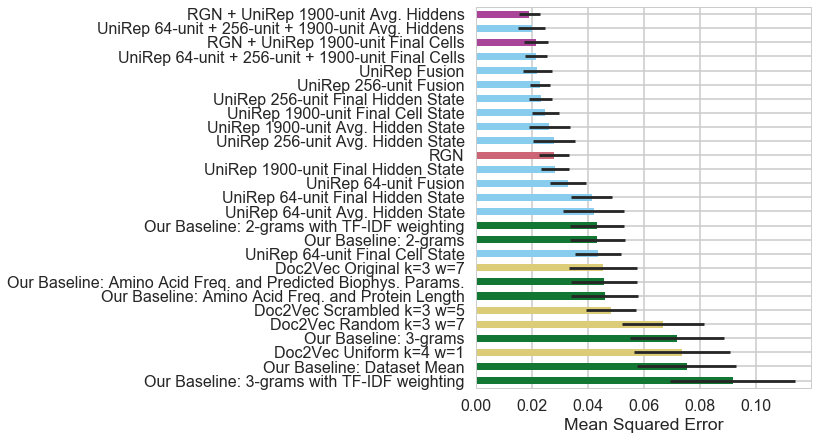

Supplementary Results Figure 18: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EEHEE_rd3_1716. 


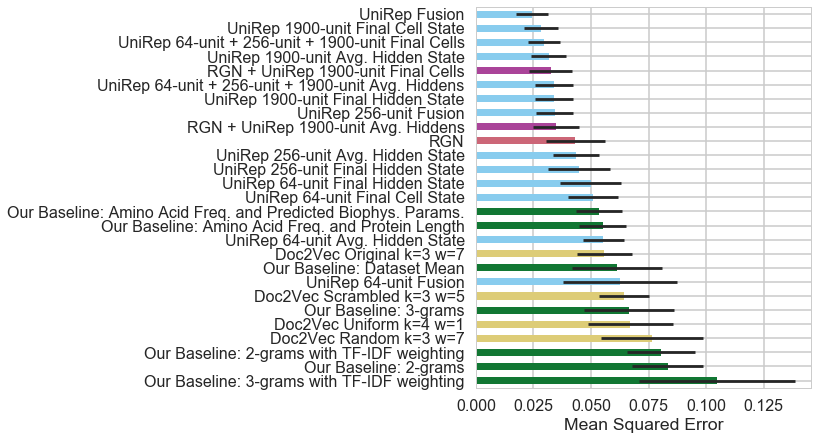

Supplementary Results Figure 19: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EHEE_0882. 


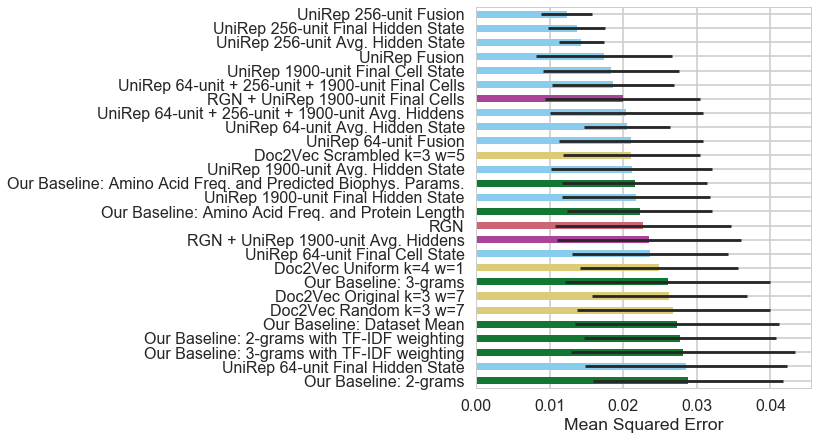

Supplementary Results Figure 20: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EHEE_rd2_0005. 


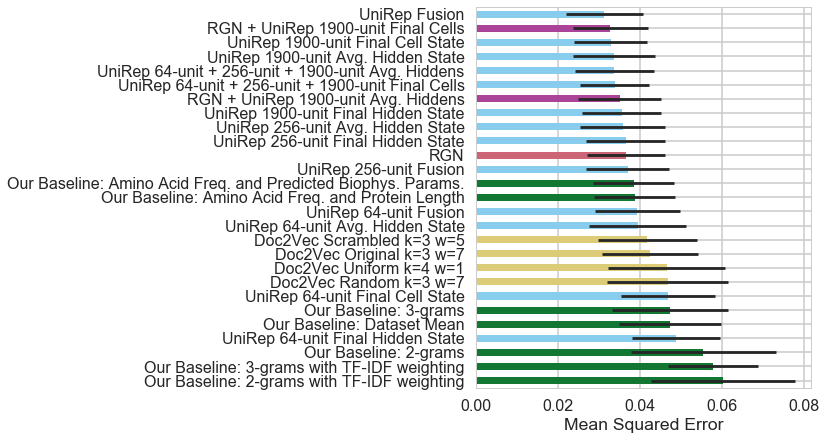

Supplementary Results Figure 21: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: EHEE_rd3_0015. 


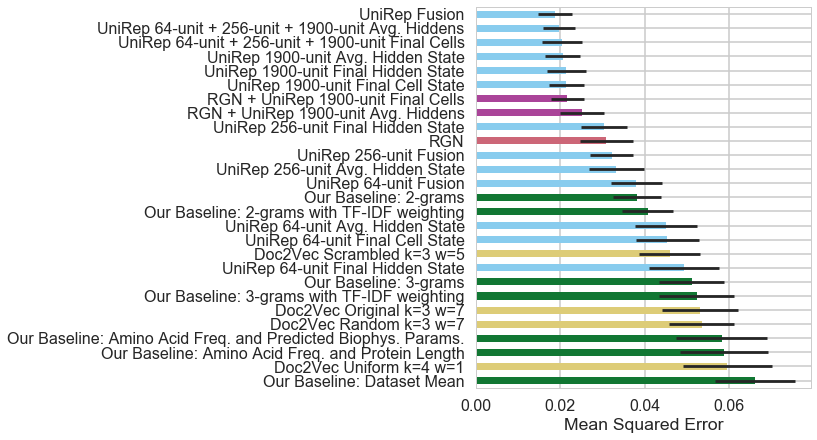

Supplementary Results Figure 22: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HEEH_rd2_0779. 


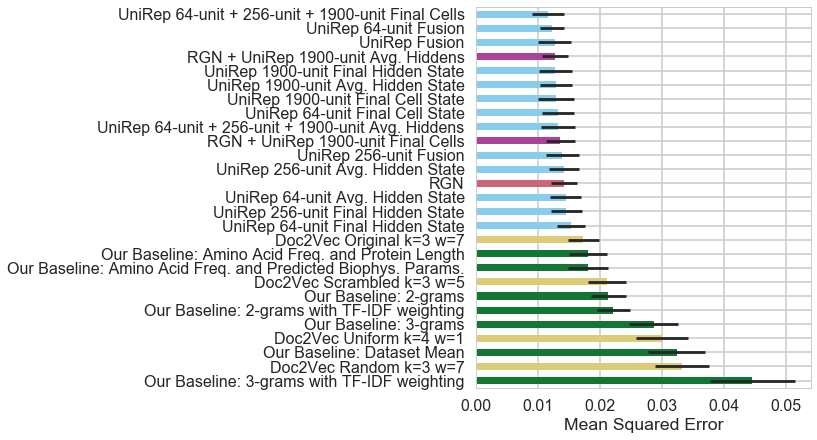

Supplementary Results Figure 23: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HEEH_rd3_0223. 


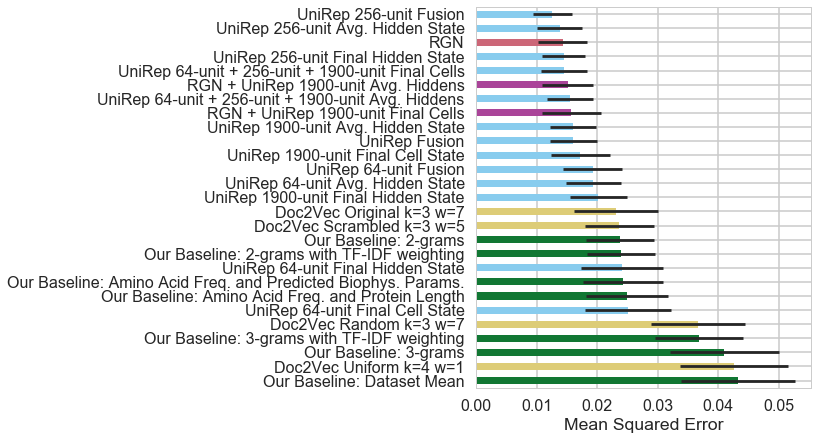

Supplementary Results Figure 24: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HEEH_rd3_0726. 


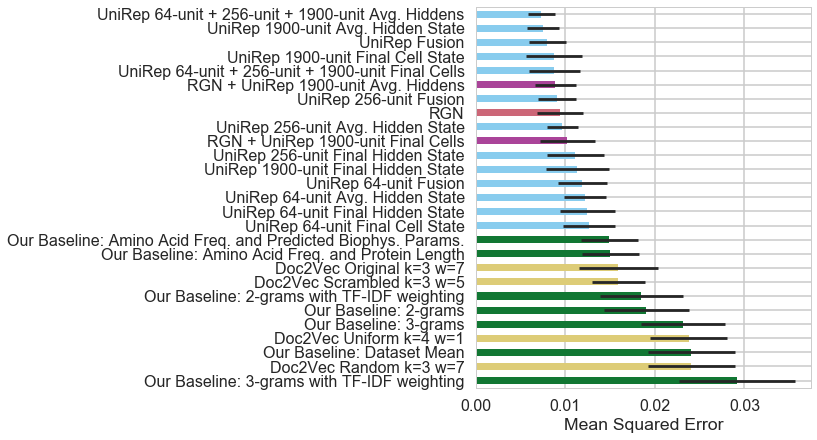

Supplementary Results Figure 25: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HEEH_rd3_0872. 


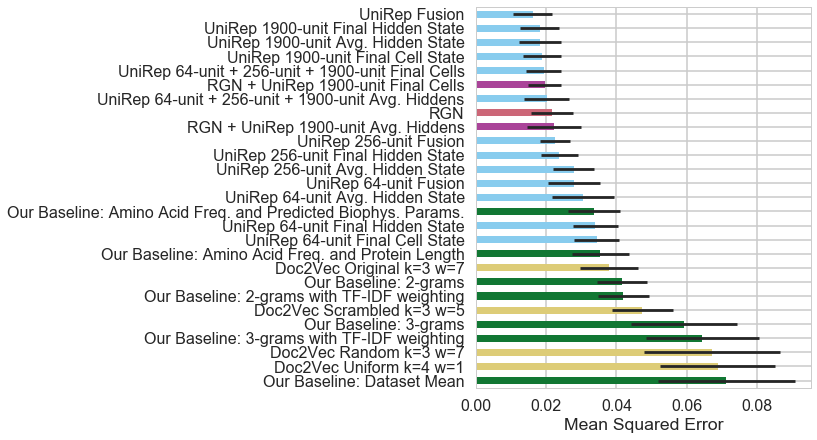

Supplementary Results Figure 26: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HHH_0142. 


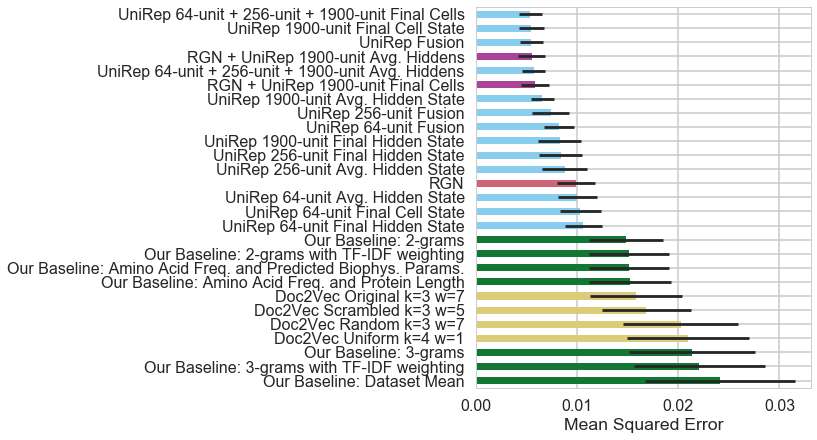

Supplementary Results Figure 27: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HHH_rd2_0134. 


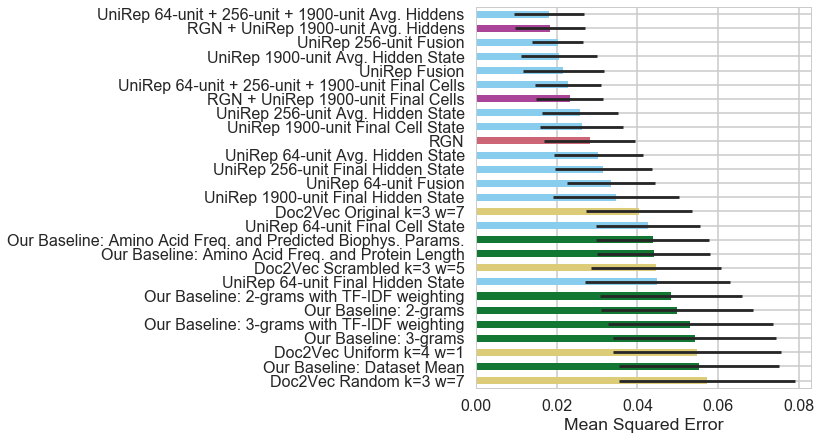

Supplementary Results Figure 28: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: HHH_rd3_0138. 


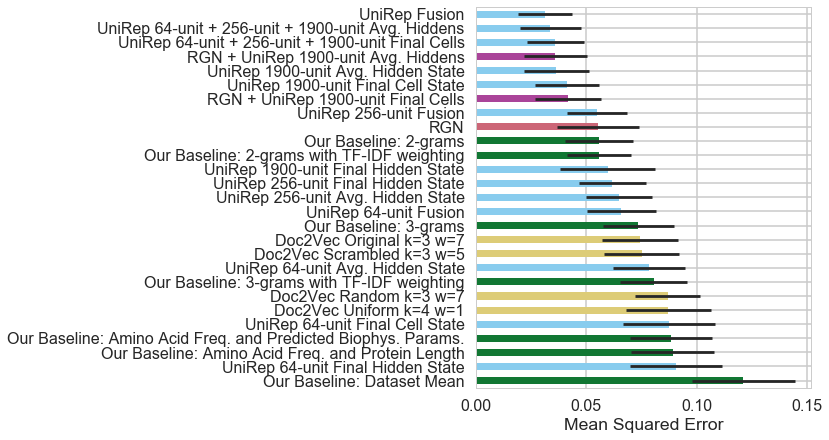

Supplementary Results Figure 29: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: Pin1. 


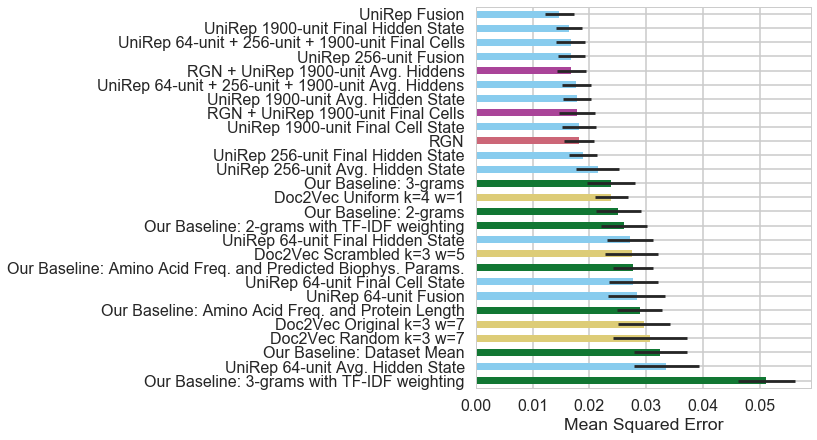

Supplementary Results Figure 30: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: hYAP65. 


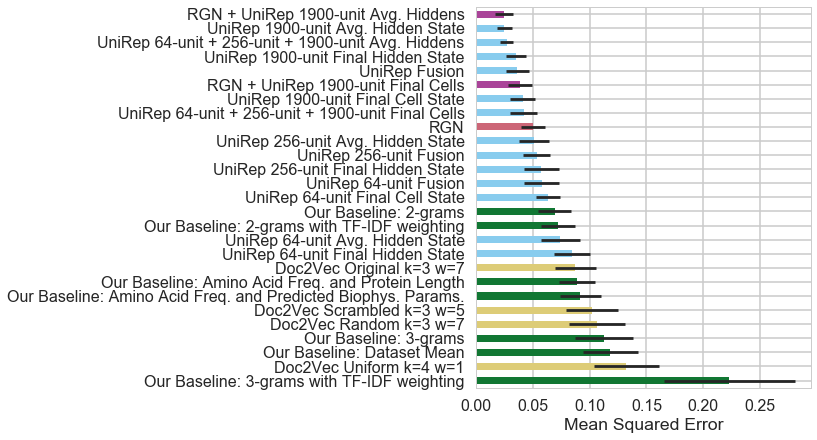

Supplementary Results Figure 31: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task. Subset: villin. 


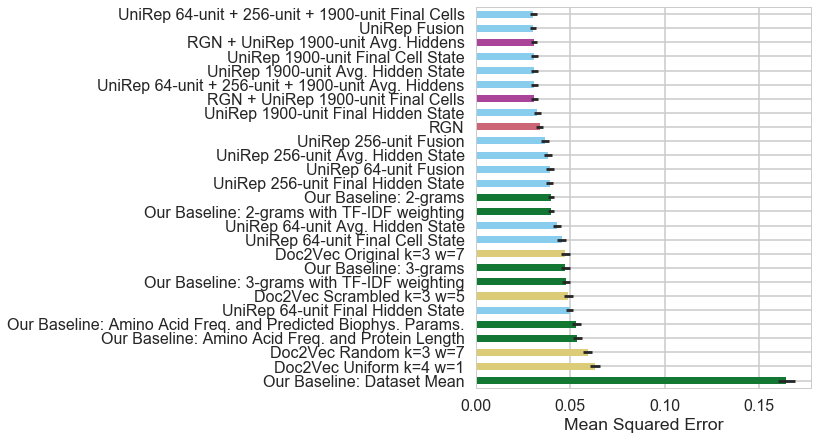

Supplementary Results Figure 32: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis task, Combined Data. 


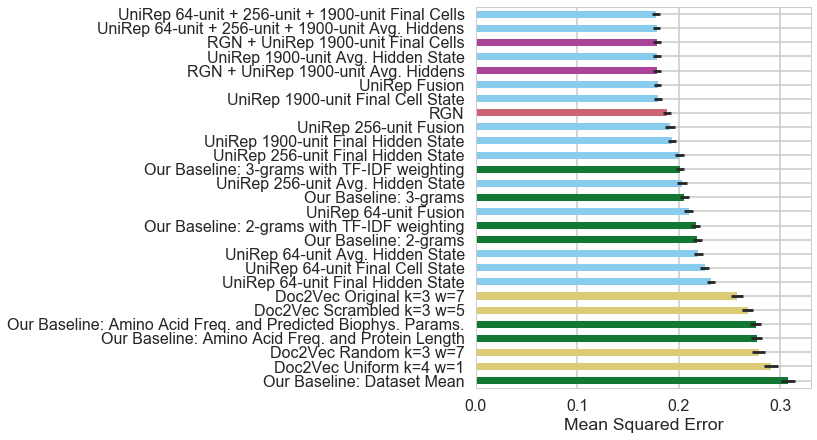

Supplementary Results Figure 33: All representation results in de-novo designed proteins stability - design rounds task. 


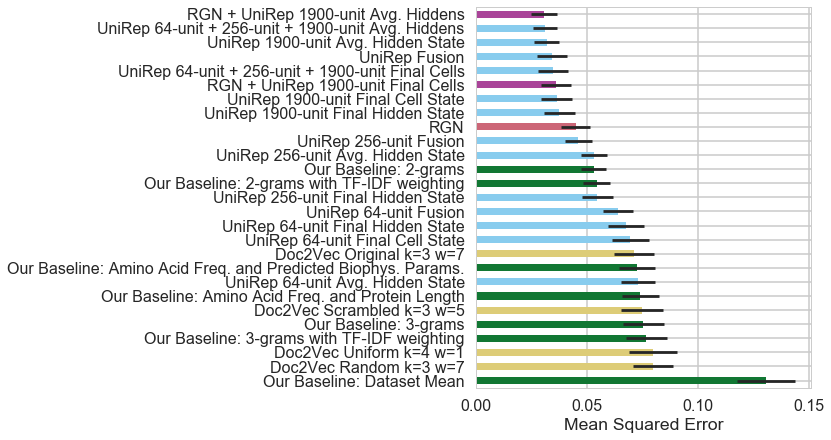

Supplementary Results Figure 34: All representation results in natural & de-novo designed mutant proteins stability - site saturation mutagenesis task. Subset: Natural. 


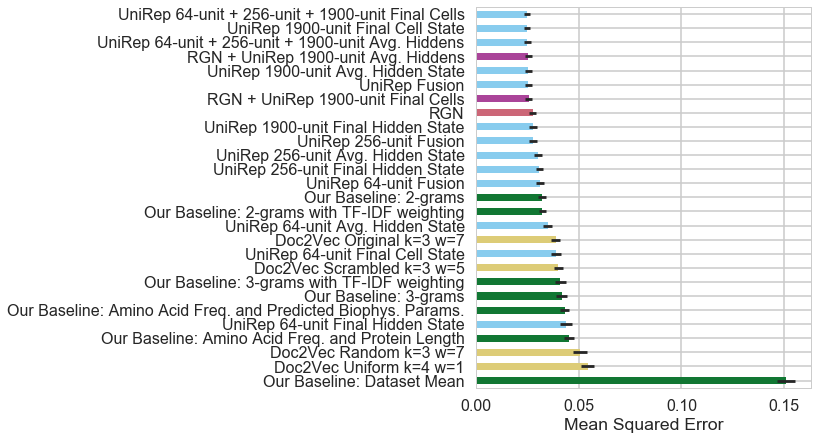

Supplementary Results Figure 35: All representation results in natural & de-novo designed mutant proteins stability - site saturation mutagenesis task. Subset: De-Novo Designed. 


In [51]:
# 9*6 inches

tab_dict = get_tab_dict_and_plot('mse', to_plot=True, figsize=(6,7))

In [52]:
tab_dict_nontransfer = tab_dict.copy()

In [53]:
tab_dict_nontransfer

{('arnold_T50', 'T50'):                                 avg         stdev
 simple_freq_and_len   179962.444223  67987.358686
 simple_freq_plus        6720.300799   2908.024350
 final_hidden              71.662336     15.226777
 64_final_hidden           68.202886     30.204846
 mean                      50.970891     16.678729
 64_final_cell             48.212309     19.378566
 256_avg_hidden            41.113873     10.939631
 all_final_cell            40.690867     22.641076
 RGN_final_cell            34.771925     10.981358
 all_avg_hidden            30.258306      6.959241
 3grams                    29.963545     10.440956
 final_cell                28.496585     15.768511
 64_avg_hidden             27.623735      7.325686
 arnold_random_3_7         26.907864      7.827427
 all_64                    26.881790      6.641446
 arnold_scrambled_3_5      26.714502     11.091107
 tfidf_3grams              26.623020      5.712574
 RGN                       24.388218      9.566020
 tfidf_2

In [54]:
regr_datasets = ['leuenberger', 'solubility']

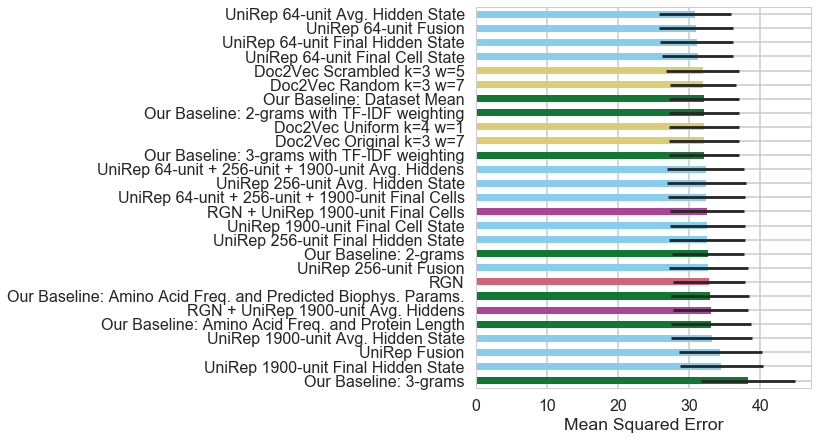

Supplementary Results Figure 36: All representation results in thermostability prediction across organisms task. Subset: H. Sapiens. 


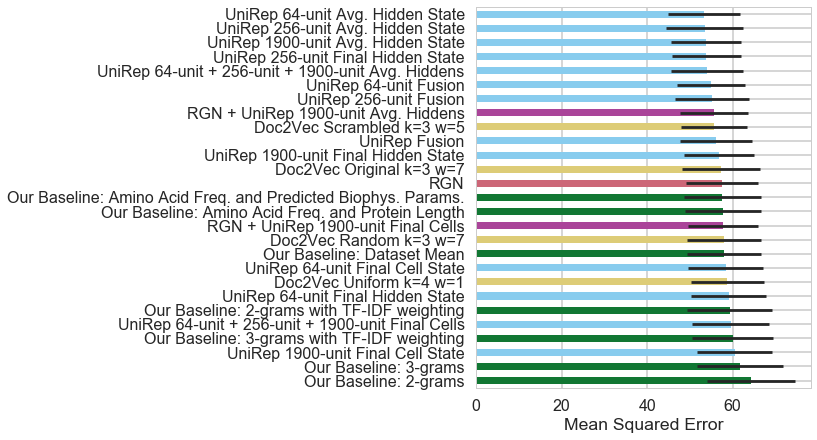

Supplementary Results Figure 37: All representation results in thermostability prediction across organisms task. Subset: E. Coli. 


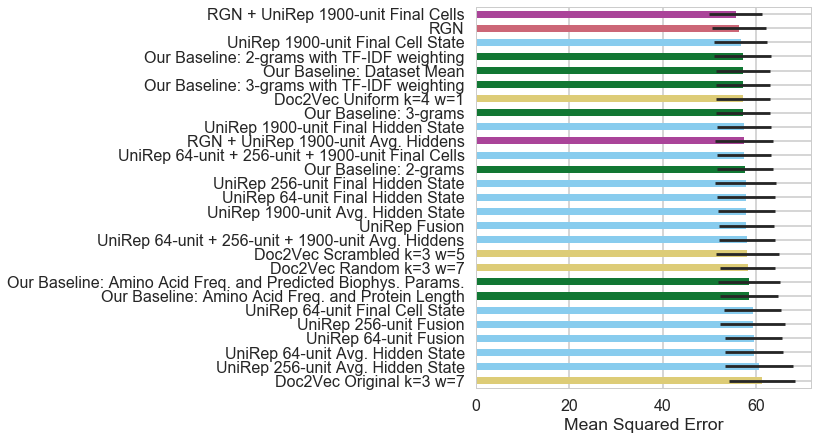

Supplementary Results Figure 38: All representation results in thermostability prediction across organisms task. Subset: S. Thermophilus. 


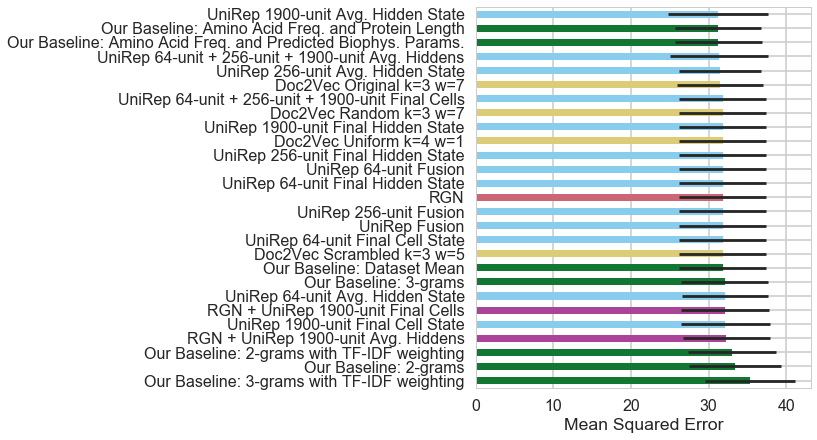

Supplementary Results Figure 39: All representation results in thermostability prediction across organisms task. Subset: S. Cerevisiae. 


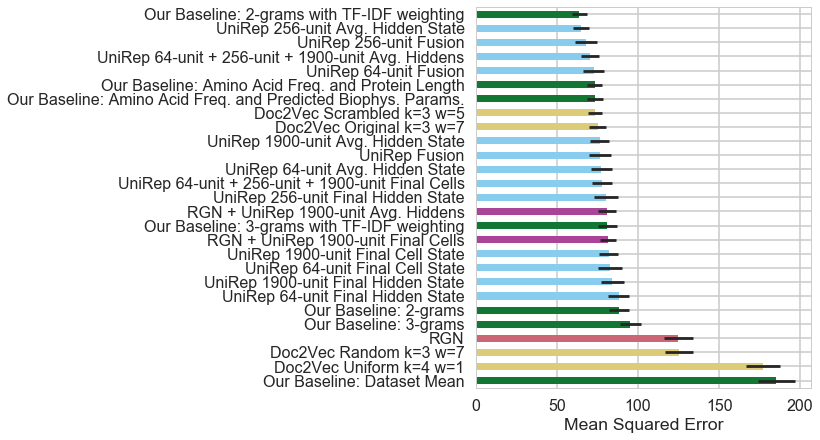

Supplementary Results Figure 40: All representation results in thermostability prediction across organisms task, Combined Data. 


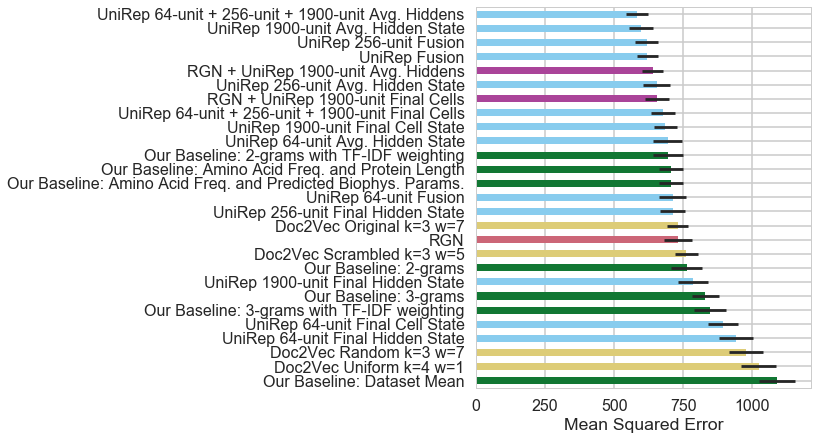

Supplementary Results Figure 41: All representation results in protein solubility prediction task. Subset: E. Coli. 


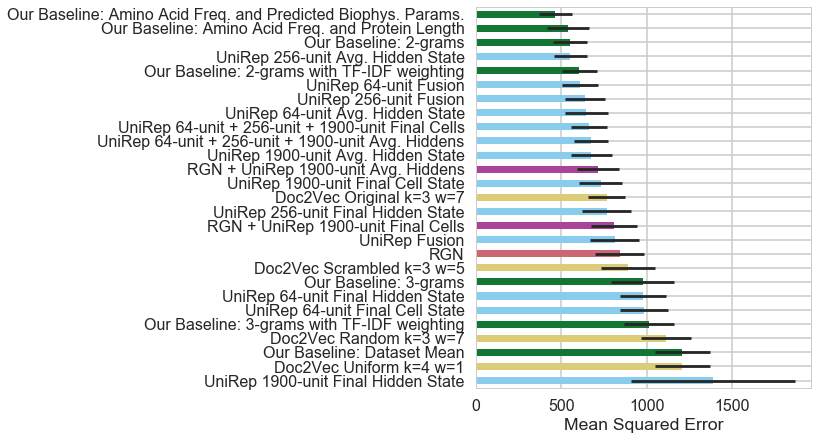

Supplementary Results Figure 42: All representation results in protein solubility prediction task. Subset: S. Cerevisiae. 


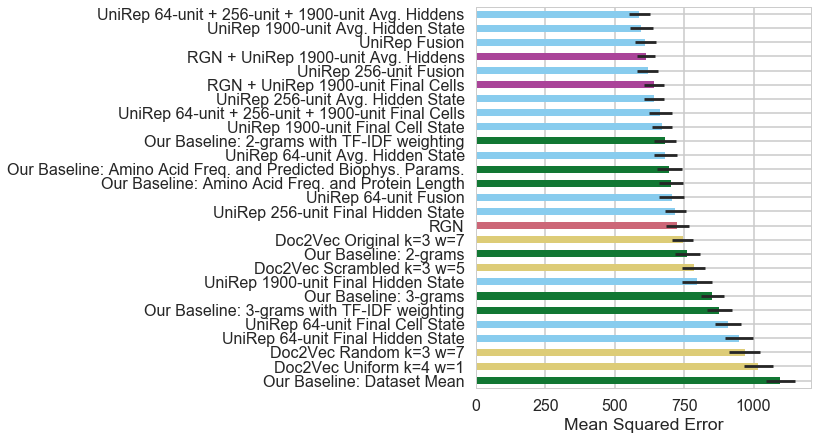

Supplementary Results Figure 43: All representation results in protein solubility prediction task, Combined Data. 


In [55]:
tab_dict = get_tab_dict_and_plot('mse', to_plot=True, figsize=(6,7))

In [56]:
tab_dict_excluded = tab_dict.copy()

In [57]:
# This only needs to be ran once if the results folder has just been updated by the script
# It makes transfer scores consistent with the original Gray 2018 paper

# from sklearn.externals import joblib

# res = joblib.load("./results_UBI4_correction.mkl")

# for run_type in ['validate','test','train']:
#     print(run_type)
#     for rep in reps: #np.setdiff1d(reps,['mean']):
#         print(rep)
#         df = pd.read_csv(f"./results/transfer__fowler_consistent_single_UBI__{rep}__{run_type}__metrics.csv", index_col=0)
#         new = pd.concat([res[run_type][rep]['E1_Ubiquitin'], res[run_type][rep]['Ubiquitin']], axis=1).T
#         new.index = ['E1_Ubiquitin','Ubiquitin']
#         new_metrics = pd.concat([
#             df[df.index != 'UBI4_combined'], new
#         ])
#         display(new_metrics)

#         new_metrics.to_csv(f"./results/transfer__fowler_consistent_single_UBI__{rep}__{run_type}__metrics.csv")
#         results_eval_on_holdout = pd.DataFrame(columns= ['transfer_ratio_avg', 'indomain_ratio_avg'])
#         results_eval_on_holdout.loc[rep,:] = new_metrics[['transfer_ratio', 'indomain_ratio']].mean().values
#         results_eval_on_holdout.to_csv(f"./results/transfer__fowler_consistent_single_UBI__{rep}__{run_type}__results_eval_on_holdout.csv")
        

In [58]:
metric = 'transfer_ratio_avg'
ascending = False

def get_transfer_result_dfs(path_to_results_folder, prefix="transfer__"):
    li = pd.Series(os.listdir(path_to_results_folder))
    li = li[li.str.contains("transfer") & li.str.contains("results") & li.str.contains(run_type)]
    
    res_dfs = {}
        
    for dataset_name in transfer_datasets:
        
        df = pd.concat([
            pd.read_csv(
                        os.path.join(path_to_results_folder,line),
                        index_col=0
                    ) for line in li[li.str.startswith(prefix+dataset_name+"__")]
        ])
        df['perf_ratio_avg'] = df['transfer_ratio_avg'] / df['indomain_ratio_avg']
        
        res_dfs[dataset_name] = df
    
    return res_dfs

# This cell computes std dataframe from errors in the results folder - this is std of results 
# from different hold-one-out runs. Has the same index and columns as the original results dataframes in the 
# dict above - this is for passing in xerr argument in plot
def get_transfer_std_dfs(path_to_results_folder, prefix="transfer__"):

    li = pd.Series(os.listdir(path_to_results_folder))
    li = li[li.str.contains("transfer") & li.str.contains("metrics")  & li.str.contains(run_type)]

    std_dfs = {}
    for d in transfer_datasets:
        std_df = pd.DataFrame(index=reps, columns=['transfer_ratio_avg', 'indomain_ratio_avg', 'perf_ratio_avg'])
        for rep in reps:
            df = pd.read_csv(os.path.join(path_to_results_folder, 
                                                       li[
                                                             li.str.startswith(prefix+d+"__") & li.str.contains(rep)
                                                        ].iloc[0]),
                                          index_col=0)
            df['perf_ratio'] = df['transfer_ratio'] / df['indomain_ratio']
            std_df.loc[rep] = df[['transfer_ratio', 'indomain_ratio', 'perf_ratio']].std().values
        std_dfs[d] = std_df

    return std_dfs

def get_original_dfs(path_to_results_folder, prefix="transfer__"):

    li = pd.Series(os.listdir(path_to_results_folder))
    li = li[li.str.contains("transfer") & li.str.contains("metrics")  & li.str.contains(run_type)]

    original_dfs = {}
    for d in transfer_datasets:
        o_df = {}
        for rep in reps:
            df = pd.read_csv(os.path.join(path_to_results_folder, 
                                                       li[
                                                             li.str.startswith(prefix+d+"__") & li.str.contains(rep)
                                                        ].iloc[0]),
                                          index_col=0)
            o_df[rep] = df
        original_dfs[d] = o_df
    return original_dfs

path_to_results_folder = "../../../data/results/"
transfer_results = get_transfer_result_dfs(path_to_results_folder)
std_dfs = get_transfer_std_dfs(path_to_results_folder)
original_dfs = get_original_dfs(path_to_results_folder)

group_assignment = {'RGN': 'rgn',
 '64_avg_hidden': 'uni',
 '64_final_hidden': 'uni',
 '64_final_cell': 'uni',
 '256_avg_hidden': 'uni',
 '256_final_cell': 'uni',
 'avg_hidden': 'uni',
 'final_hidden': 'uni',
 'final_cell': 'uni',
 'arnold_original_3_7': 'arnold',
 'arnold_scrambled_3_5': 'arnold',
 'arnold_random_3_7': 'arnold',
 'arnold_uniform_4_1': 'arnold',
 'all_64': 'uni',
 'all_256': 'uni',
 'all_1900': 'uni',
 'all_avg_hidden': 'uni',
 'all_final_cell': 'uni',
 'RGN_avg_hidden': 'fusion',
 'RGN_final_cell': 'fusion',
 'simple_freq_plus': 'baseline',
 'simple_freq_and_len': 'baseline',
 '2grams': 'baseline',
 '3grams': 'baseline',
 'tfidf_2grams': 'baseline',
 'tfidf_3grams': 'baseline',
 'mean': 'baseline'}

marker_assignment = {
                     
 'all_1900': 'o',
 'all_64': 'D',
 'all_256': '*',
 'all_avg_hidden': 'p',
 'all_final_cell': '<',
 'avg_hidden': 'h',
 'final_hidden': '^',
 'final_cell': 'X',
                     
 '64_avg_hidden': 's',
 '64_final_hidden': '>',
 '64_final_cell': '$\mathbf{<}$',
 '256_avg_hidden': '$V$',
 '256_final_cell': '$L$',

 
 'RGN': '$\mathbf{o}$',
                     
 'arnold_original_3_7': '^',
 'arnold_scrambled_3_5': 'v',
 'arnold_random_3_7': '>',
 'arnold_uniform_4_1': '<',

 'RGN_avg_hidden': 'X',
 'RGN_final_cell': 'd',
                     
 'simple_freq_plus': '$\mathbf{+}$',
 'simple_freq_and_len': '$\mathbf{f}$',
 '2grams': 'D',
 '3grams': '$\mathbf{V}$',
 'tfidf_2grams': 'o',
 'tfidf_3grams': '$\mathbf{+}$',
 'mean': '$\mathbf{m}$'}

group_assignment_rev = pd.Series(group_assignment).to_frame()
group_assignment_rev = group_assignment_rev.reset_index().set_index(0)
group_assignment_rev.columns = ['rep']

def plot_2d_transfer(df, figsize=(6,8), horizalign=['left','right'], lims=False):
    df = df.loc[df.sort_values(by='transfer_ratio_avg').index]
    fig, ax = plt.subplots(figsize=figsize)
    for rep in df['indomain_ratio_avg'].index:
        #print(rep)
        color = rep_colors[rep]
        marker = marker_assignment[rep]# markers[group_assignment_rev.loc[group_assignment[rep]].reset_index()['rep'].reset_index().set_index('rep').loc[rep].values[0]]

        #print(rep,marker)
        ax.plot(df['indomain_ratio_avg'].loc[rep], df['transfer_ratio_avg'].loc[rep], 
                color=color, 
                marker= marker,
                mew = 0.25,
                mec='black',
                label= plot_style_utils.rep_names[rep])
    ax.legend(handlelength=0, fontsize='x-small', ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.text(df.loc['all_1900','indomain_ratio_avg'], df.loc['all_1900','transfer_ratio_avg'], plot_style_utils.rep_names['all_1900'], horizontalalignment=np.random.choice(horizalign), size='12', color='black') # , weight='semibold'

    if lims:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    plt.xlabel('Average In-Domain Ratio')
    plt.ylabel('Average Transfer Ratio')
    
#     for line in range(0,df.shape[0]):
#         if lims==False:
#             plt.text(df['indomain_ratio_avg'][line], df['transfer_ratio_avg'][line], df.index[line], horizontalalignment=np.random.choice(horizalign), size='12', color='black') # , weight='semibold'
#         else:
#             if (df['indomain_ratio_avg'][line] < lims[0][1]) & (df['transfer_ratio_avg'][line] < lims[1][1]) & (df['transfer_ratio_avg'][line] > lims[1][0]) & (df['indomain_ratio_avg'][line] > lims[0][0]):
#                 plt.text(df['indomain_ratio_avg'][line], df['transfer_ratio_avg'][line], df.index[line], horizontalalignment=np.random.choice(horizalign), size='12', color='black') # , weight='semibold'
    return fig, ax

In [59]:
transfer_results['rocklin_ssm2'].loc['all_1900']

transfer_ratio_avg    2.640831
indomain_ratio_avg    0.704246
perf_ratio_avg        3.749870
Name: all_1900, dtype: float64

In [70]:
transfer_datasets = ['fowler_consistent_single_UBI', 'rocklin_ssm2']

In [71]:
fig_n=44

In [72]:
run_type

'test'

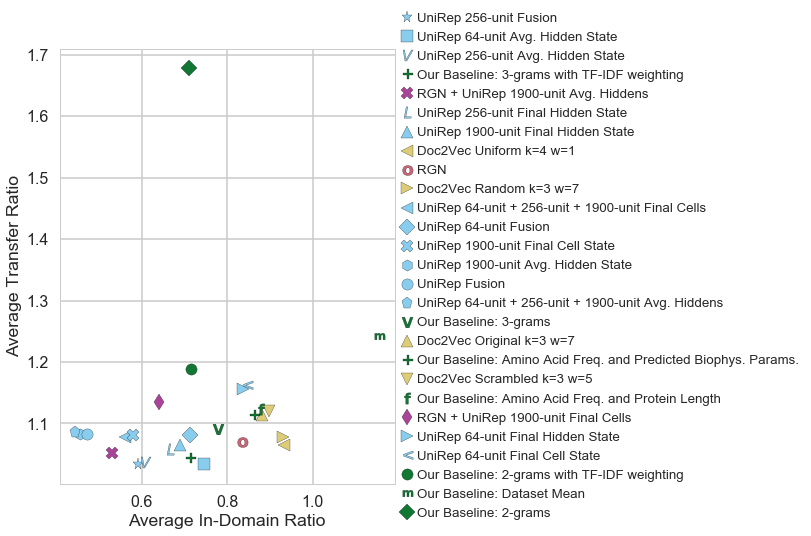


 Supplementary Figure 44: All representation results in variant effect prediction task transfer task. 


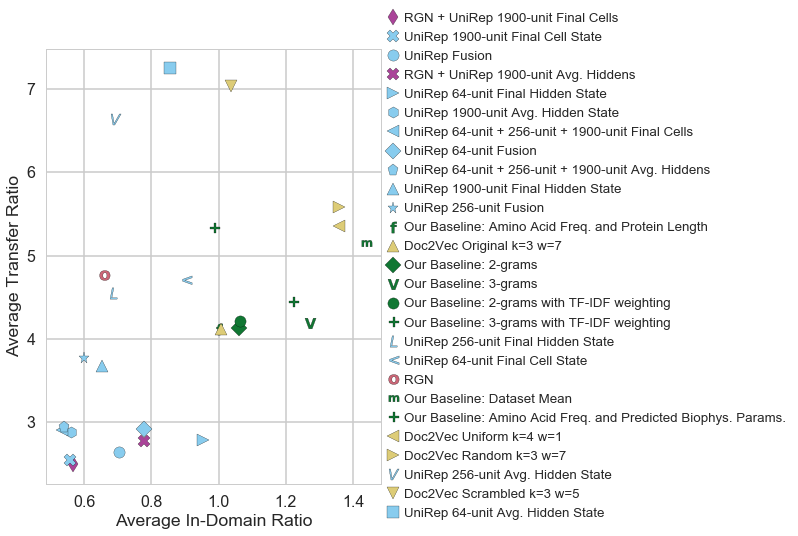


 Supplementary Figure 45: All representation results in natural & de-novo designed proteins stability - site saturation mutagenesis transfer task. 


In [73]:
for d in transfer_datasets:
    fig, ax = plot_2d_transfer(transfer_results[d], horizalign=['left'])
    display(fig)
    printmd(f"\n Supplementary Figure {fig_n}: All representation results in {task_names[d].lower()} transfer task. \n")
    #printmd("\n\n")
    plt.close()
    #common_v2.plot_style_utils.save_for_pub(fig=fig, path=f"./figures/transfer_{d}", dpi=500)
    fig_n +=1

In [74]:
def get_spec_transfer_nonavg_result_dfs(d='rocklin_ssm2_nat_eng', withheld_subset = 'natural'):

    res_df = {}
    for rep in reps:

        df = pd.read_csv(f"../../../data/results/transfer__{d}__{rep}__{run_type}__metrics.csv", index_col=0).loc[withheld_subset]

        res_df[rep] = df
    
    res_df = pd.DataFrame(res_df).T
    
    res_df['perf_ratio'] = res_df['transfer_ratio'] / res_df['indomain_ratio']
    
    res_df = res_df[['transfer_ratio', 'indomain_ratio', 'perf_ratio']]
    res_df.columns = ['transfer_ratio_avg', 'indomain_ratio_avg', 'perf_ratio_avg'] # not actually avg, just easier
    
    return res_df

Supplementary Figure 46: 
 All representation results in natural & de-novo designed mutant proteins stability - remote transfer task. 


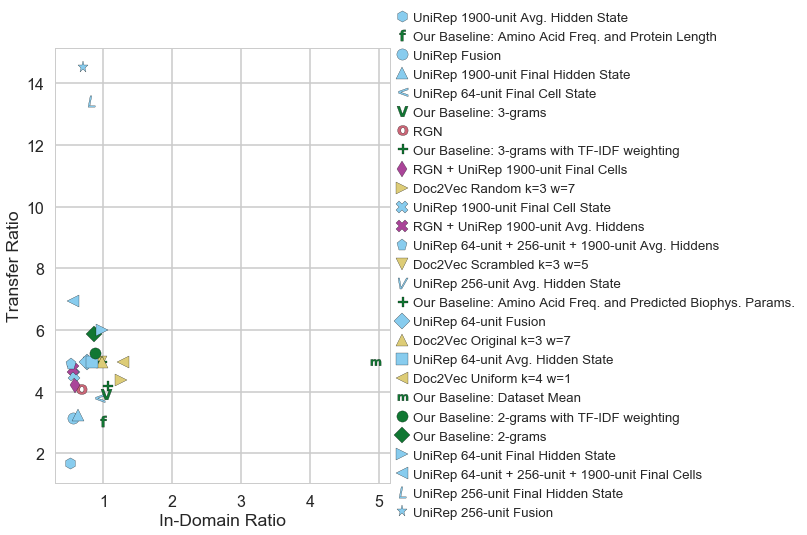

In [75]:
printmd(f"Supplementary Figure {fig_n}: \n All representation results in {task_names['rocklin_ssm2_remote_test'].lower()} transfer task. \n")
fig, ax = plot_2d_transfer(
    get_spec_transfer_nonavg_result_dfs(d='rocklin_ssm2_remote_test', withheld_subset = 'remote')
)
plt.xlabel("In-Domain Ratio")
plt.ylabel("Transfer Ratio")
display(fig)
plt.close()
#plot_style_utils.save_for_pub(fig=fig, path=f"./figures/transfer_rocklin_ssm2_remote_test", dpi=500)

# Supp Data 1, 2

In [236]:
writer = pd.ExcelWriter(f'./all_results_{run_type}.xlsx')

In [237]:
tab_dict_nontransfer

{('arnold_T50', 'T50'):                             avg     stdev
 mean                  41.579640  8.835501
 tfidf_2grams          17.758963  4.677646
 tfidf_3grams          16.956091  4.431338
 64_final_cell         16.634848  5.977447
 3grams                14.054248  3.282141
 64_final_hidden       13.845695  4.357995
 arnold_original_3_7   10.508323  2.500350
 RGN                   10.256593  3.061008
 RGN_final_cell        10.111589  2.027284
 arnold_uniform_4_1     9.978525  1.603528
 64_avg_hidden          9.166260  1.635225
 arnold_scrambled_3_5   9.093767  1.592252
 final_hidden           9.024435  2.312843
 simple_freq_plus       8.994521  1.594076
 simple_freq_and_len    8.787752  1.854949
 arnold_random_3_7      8.683629  1.571212
 all_1900               8.298316  1.423916
 2grams                 8.265683  1.378624
 final_cell             8.175822  1.741353
 avg_hidden             7.801847  1.316039
 all_avg_hidden         7.495430  1.370762
 RGN_avg_hidden         7.17376

In [238]:
tab_dict_excluded

{('leuenberger', 'human_tm'):                             avg     stdev
 3grams                47.851615  5.611548
 2grams                46.938457  5.681852
 simple_freq_plus      46.752280  5.606316
 RGN                   46.518516  5.711455
 simple_freq_and_len   46.488024  5.545508
 arnold_random_3_7     46.477388  5.575012
 mean                  46.467176  5.721118
 tfidf_2grams          46.467176  5.721118
 arnold_uniform_4_1    46.467176  5.721118
 arnold_original_3_7   46.467176  5.721118
 tfidf_3grams          46.450203  5.715217
 final_hidden          46.391443  5.771894
 RGN_avg_hidden        46.331979  5.541855
 RGN_final_cell        45.971444  5.494017
 64_final_cell         45.930997  5.459847
 arnold_scrambled_3_5  45.891132  5.503570
 all_1900              45.829079  5.487007
 64_final_hidden       45.791704  5.448700
 256_final_cell        45.760764  5.647063
 final_cell            45.619593  5.366854
 all_final_cell        45.506068  5.327405
 all_64                45

In [239]:
transfer_results['rocklin_ssm2_remote_test'] = get_spec_transfer_nonavg_result_dfs(d='rocklin_ssm2_remote_test', withheld_subset = 'remote')
transfer_results

{'fowler_consistent_single_UBI':                       transfer_ratio_avg  indomain_ratio_avg  perf_ratio_avg
 simple_freq_and_len             1.127652            0.954098        1.181904
 all_avg_hidden                  1.074280            0.715257        1.501949
 arnold_random_3_7               1.070181            0.909810        1.176269
 arnold_original_3_7             1.102789            0.934536        1.180039
 all_1900                        1.077761            0.661425        1.629452
 simple_freq_plus                1.120408            0.972534        1.152050
 arnold_uniform_4_1              1.042189            0.963253        1.081947
 RGN                             1.055718            0.929324        1.136007
 3grams                          1.088737            0.756244        1.439663
 64_final_hidden                 1.113217            0.969481        1.148260
 arnold_scrambled_3_5            1.115306            0.958346        1.163783
 64_final_cell                  

In [240]:
for n in tab_dict_nontransfer.keys():
    sheet_name = plot_style_utils.task_names[n[0]]+" "+n[1]
    tab_dict_nontransfer[n].to_excel(writer, sheet_name=sheet_name)
    
for n in tab_dict_excluded.keys():
    sheet_name = plot_style_utils.task_names[n[0]]+" "+n[1]
    tab_dict_excluded[n].to_excel(writer, sheet_name=sheet_name)
    
for n in transfer_results.keys():
    sheet_name = plot_style_utils.task_names[n]
    transfer_results[n].to_excel(writer, sheet_name=sheet_name)

/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/op

/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [241]:
writer.save()

# Supp Fig S9

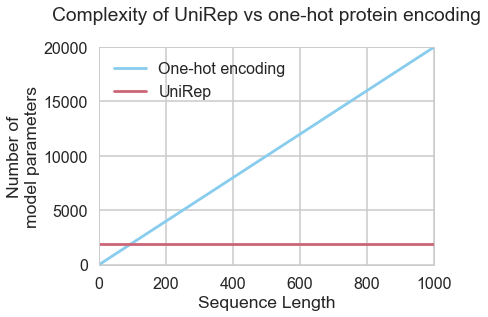

In [80]:
def one_hot_params(l):
    return 20*l+1

def UniRep_params(l):
    return 1900+1

max_l=1000

fig = plt.figure()
plt.plot(np.arange(max_l),[one_hot_params(l) for l in np.arange(max_l)], label='One-hot encoding')
plt.plot(np.arange(max_l),[UniRep_params(l) for l in np.arange(max_l)], label='UniRep')
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Number of\nmodel parameters")
plt.title("Complexity of UniRep vs one-hot protein encoding\n")
plt.xlim(0,1000)
plt.ylim(0,20000)
#plot_style_utils.save_for_pub(fig=fig, path="./figures/supplemental_complexity_unirep_one_hot")

# Supp. Fig S12

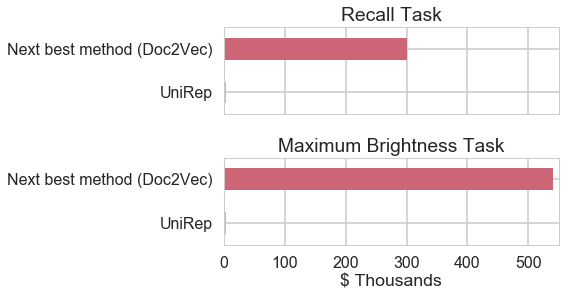

In [313]:
fig, axs = plt.subplots(2,1)

plt.subplots_adjust(hspace = 0.5)

pd.Series({"UniRep":3,
          "Next best method (Doc2Vec)":300}).plot(kind='barh', ax=axs[0], xlim=(0,550), title="Recall Task")

pd.Series({"UniRep":3,
          "Next best method (Doc2Vec)":540}).plot(kind='barh', ax=axs[1], xlim=(0,550), sharex=axs[0], title="\nMaximum Brightness Task")
axs[1].set_xlabel("$ Thousands")

#plot_style_utils.save_for_pub(fig=fig, path="./figures/cost_savings", dpi=350)